# Quality Control

## retriev data from s3 bucket

In [1]:
import os
import urllib.request
from pathlib import Path

# Set the URL for the cloud
URL = "https://js2.jetstream-cloud.org:8001/"
path = "pythia/radar/erad2024/baltrad/baltrad_short_course/"
!mkdir -p data
files = ["201405190715_SUR.h5", "plrze_pvol_20120205T0430Z.h5", "sekir.h5"]
for file in files:
    file0 = os.path.join(path, file)
    name = os.path.join("data", Path(file).name)
    if not os.path.exists(name):
        print(f"downloading, {name}")
        urllib.request.urlretrieve(
            f"{URL}{file0}", os.path.join("data", Path(file).name)
        )

downloading, data/plrze_pvol_20120205T0430Z.h5


downloading, data/sekir.h5


##  Import the file I/O module along with the main RAVE module containing useful constants

In [2]:
%matplotlib inline
import matplotlib
import _raveio, _rave

## Read an input ODIM_H5 file

In [3]:
rio = _raveio.open("data/201405190715_SUR.h5")

## Create a simple plotter for B-scans, elaborating the example from the I/O exercise

In [4]:
# Two color palettes, one used in GoogleMapsPlugin, and the other from RAVE
from GmapColorMap import dbzh as dbzp
from rave_win_colors import continuous_MS as vradp


# Convert a 768-list palette to a matplotlib colorlist
def make_colorlist(pal):
    colorlist = []
    for i in range(0, len(pal), 3):
        colorlist.append([pal[i] / 255.0, pal[i + 1] / 255.0, pal[i + 2] / 255.0])
    return colorlist


# Convert lists to colormaps
dbzcl = make_colorlist(dbzp)
vradcl = make_colorlist(vradp)

# Then create a simple plotter
import matplotlib.pyplot as plt

# from types import StringType
StringType = type("")


def plot(data, colorlist=dbzcl, title="B-scan"):
    mini, maxi = data.shape.index(min(data.shape)), data.shape.index(max(data.shape))
    figsize = (16, 12) if mini == 0 else (12, 8)
    fig = plt.figure(figsize=figsize)
    plt.title(title)
    clist = (
        colorlist
        if type(colorlist) == StringType
        else matplotlib.colors.ListedColormap(colorlist)
    )
    plt.imshow(data, cmap=clist, clim=(0, 255))
    plt.colorbar(shrink=float(data.shape[mini]) / data.shape[maxi])

## Access the polar volume and plot VRAD data from the lowest scan

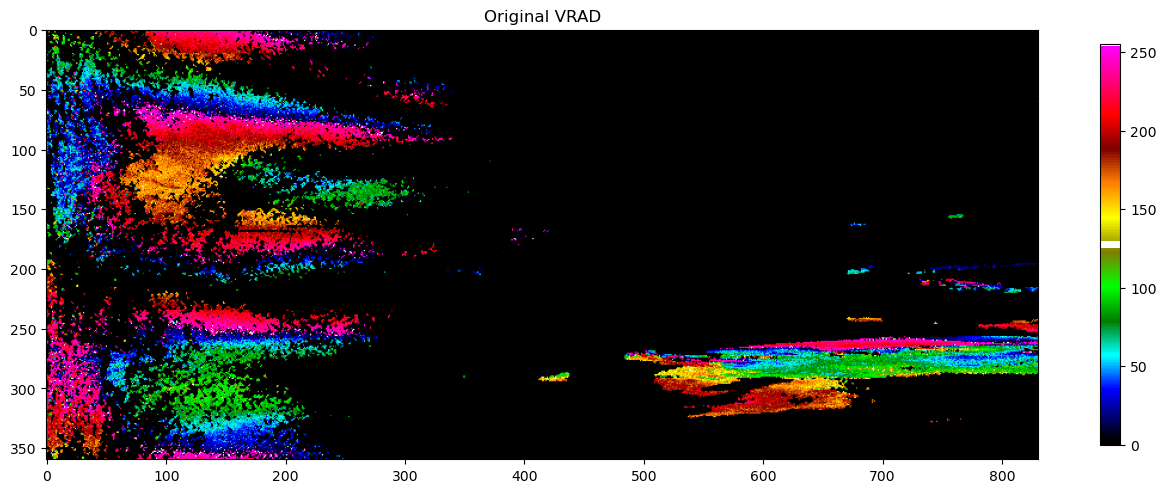

In [5]:
pvol = rio.object
plot(pvol.getScan(0).getParameter("VRADH").getData(), vradcl, "Original VRAD")

## Dealias the volume

In [6]:
import _dealias

ret = _dealias.dealias(pvol)

### Check whether the first scan's been dealiased

In [7]:
print("This first scan is dealiased: %s" % str(_dealias.dealiased(pvol.getScan(0))))

This first scan is dealiased: True


### Replot for comparison

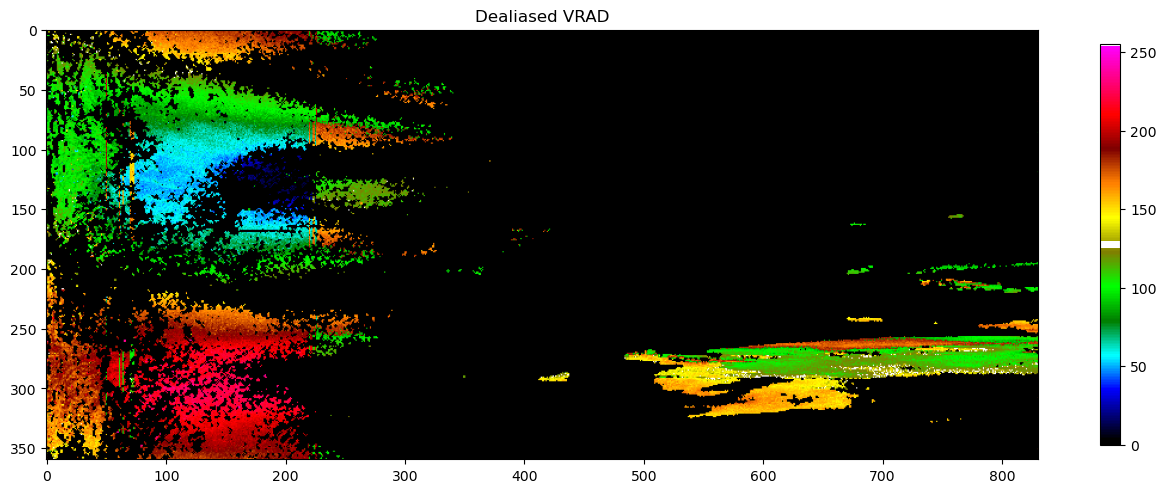

In [8]:
plot(pvol.getScan(0).getParameter("VRADH").getData(), vradcl, "Dealiased VRAD")

## Shift gears - back to reflectivity

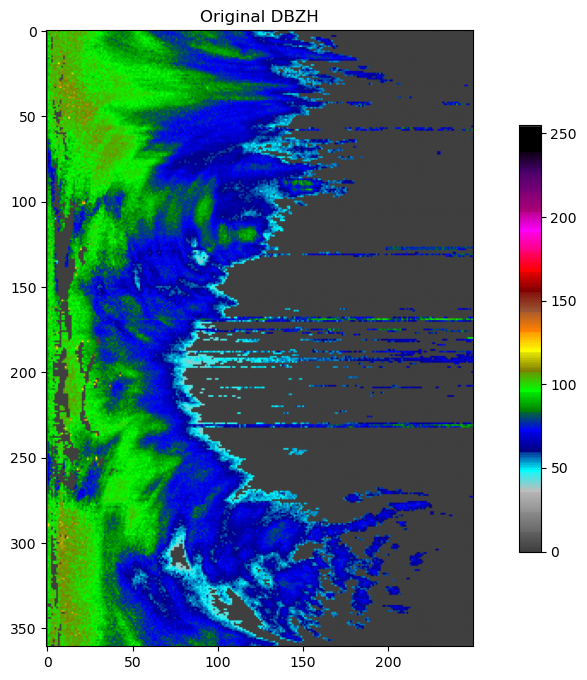

In [9]:
rio = _raveio.open("data/plrze_pvol_20120205T0430Z.h5")
pvol = rio.object
plot(pvol.getScan(0).getParameter("DBZH").getData(), title="Original DBZH")

## Use the bRopo package's quality plugin to identify and remove non-precipitation echoes

In [10]:
import odc_polarQC
import warnings

warnings.filterwarnings("ignore")  # Suppress SyntaxWarning from Python2 code

odc_polarQC.algorithm_ids = ["ropo"]
pvol = odc_polarQC.QC(pvol)

### Plot the resulting DBZH

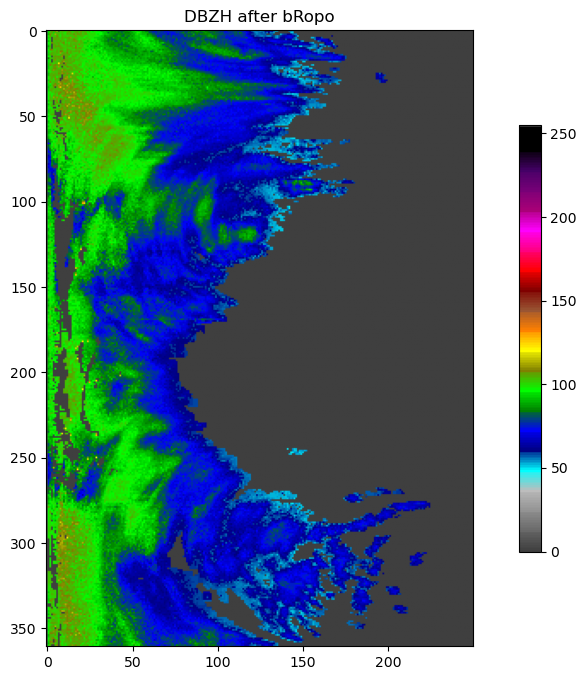

In [11]:
plot(pvol.getScan(0).getParameter("DBZH").getData(), title="DBZH after bRopo")

## Topographical beam-blockage QC using the beamb package's quality plugin

In [12]:
import time

odc_polarQC.algorithm_ids = ["beamb"]
before = time.time()
pvol = odc_polarQC.QC(pvol)
after = time.time()
print("beamb runtime = %2.2f seconds" % (after - before))

beamb runtime = 6.99 seconds


## Probability of overshooting

In [13]:
odc_polarQC.algorithm_ids = ["rave-overshooting"]
pvol = odc_polarQC.QC(pvol)

## Accessing and manging data quality fields

In [14]:
scan = pvol.getScan(0)
print("Scan contains %i quality fields" % scan.getNumberOfQualityFields())

Scan contains 3 quality fields


In [15]:
for i in range(scan.getNumberOfQualityFields()):
    qf = scan.getQualityField(i)
    print("Quality field %i has identifier %s" % (i, qf.getAttribute("how/task")))

Quality field 0 has identifier fi.fmi.ropo.detector.classification
Quality field 1 has identifier se.smhi.detector.beamblockage
Quality field 2 has identifier se.smhi.detector.poo


## Plot quality fields

### Beam blockage

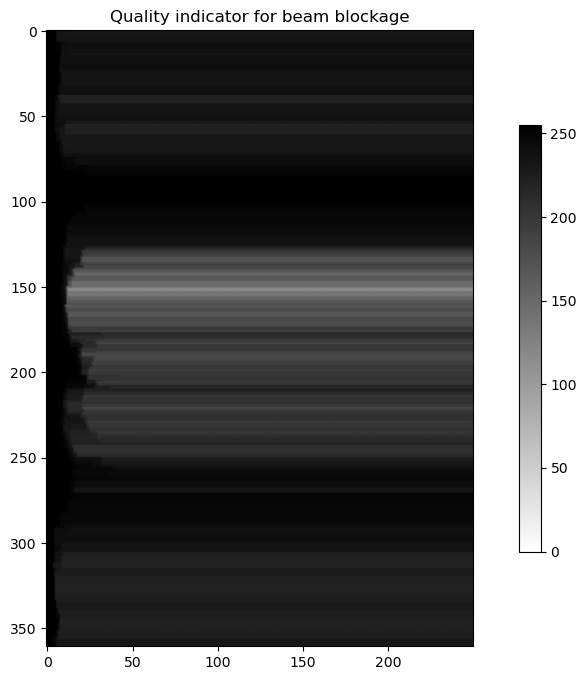

In [16]:
bb = scan.getQualityFieldByHowTask("se.smhi.detector.beamblockage")
plot(bb.getData(), "binary", "Quality indicator for beam blockage")

### Probability of non-precipitation

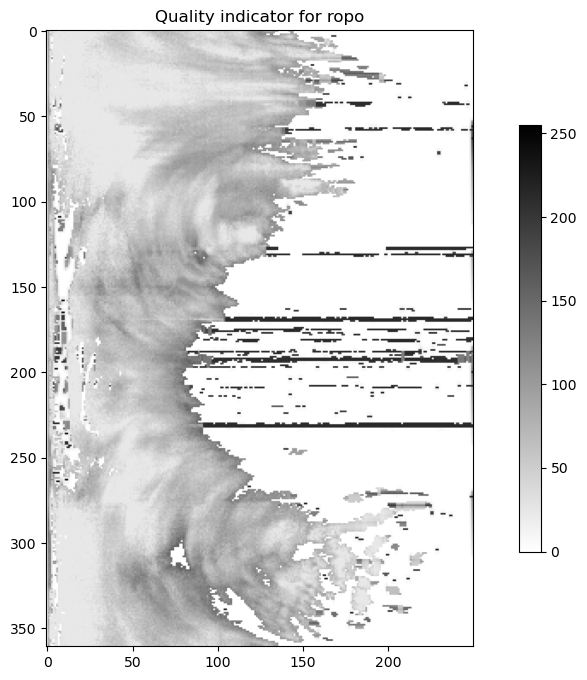

In [17]:
bb = scan.getQualityFieldByHowTask("fi.fmi.ropo.detector.classification")
plot(bb.getData(), "binary", "Quality indicator for ropo")

### Probability of overshooting

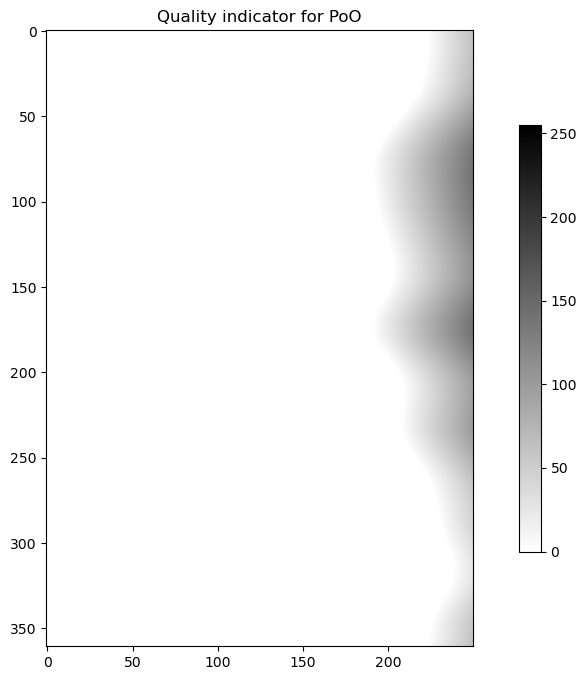

In [18]:
bb = scan.getQualityFieldByHowTask("se.smhi.detector.poo")
plot(bb.getData(), "binary", "Quality indicator for PoO")

## Chaining algorithms - new data

In [19]:
rio = _raveio.open("data/sekir.h5")
pvol = rio.object

odc_polarQC.algorithm_ids = [
    "ropo",
    "beamb",
    "radvol-att",
    "radvol-broad",
    "rave-overshooting",
]
pvol = odc_polarQC.QC(pvol)

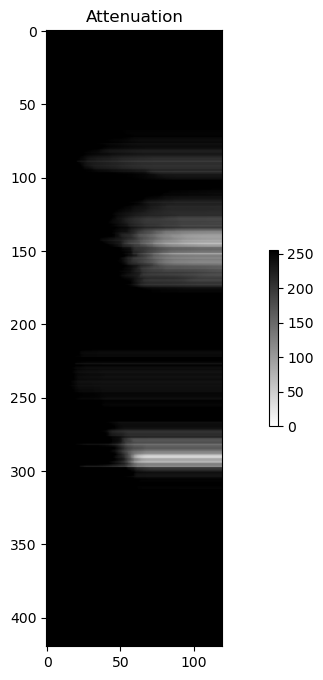

In [20]:
scan = pvol.getScan(0)
att = scan.getQualityField(2)
plot(att.getData(), "binary", "Attenuation")

## "Total Quality"

In [21]:
odc_polarQC.algorithm_ids = ["qi-total"]
pvol = odc_polarQC.QC(pvol)

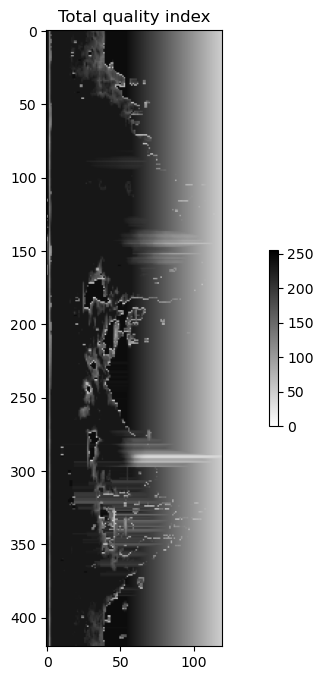

In [22]:
qitot = scan.getQualityField(5)
plot(qitot.getData(), "binary", "Total quality index")